In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Dataset path
data_path = r"E:\Collaboration Work\With Farooq\Bearings MDPI\Real paderborn"

# Step 2: Compute mean and std for custom normalization
print("🔍 Computing dataset mean and std...")
temp_dataset = datasets.ImageFolder(root=data_path, transform=transforms.ToTensor())
temp_loader = DataLoader(temp_dataset, batch_size=32, shuffle=False)

def compute_mean_std(loader):
    mean = 0.
    std = 0.
    total = 0
    for imgs, _ in loader:
        imgs = imgs.view(imgs.size(0), imgs.size(1), -1)
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)
        total += imgs.size(0)
    mean /= total
    std /= total
    return mean, std

mean, std = compute_mean_std(temp_loader)

# Step 3: Reload dataset with custom normalization
print("📦 Loading dataset with computed normalization...")
final_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])
dataset = datasets.ImageFolder(root=data_path, transform=final_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
class_names = dataset.classes
np.save("class_names.npy", class_names)

# Step 4: Load pretrained models
print("⚙️ Loading EfficientNet-B0 and ResNet50...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
effnet.classifier = nn.Identity()
effnet = effnet.to(device).eval()

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet.fc = nn.Identity()
resnet = resnet.to(device).eval()

# Step 5: Feature extraction
print("🔎 Extracting dual CNN features...")
def extract_dual_features(model1, model2, dataloader):
    features, labels = [], []
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Extracting Dual Features"):
            x = x.to(device)
            out1 = model1(x)
            out2 = model2(x)
            out = torch.cat((out1, out2), dim=1).cpu().numpy()
            features.append(out)
            labels.append(y.numpy())
    return np.vstack(features), np.concatenate(labels)

features, labels = extract_dual_features(effnet, resnet, dataloader)

# Step 6: Standardize features
print("⚖️ Standardizing features...")
scaler = StandardScaler()
features_std = scaler.fit_transform(features)

# Step 7: Apply UMAP with supervised learning
print("🧠 Applying supervised UMAP...")
reducer = umap.UMAP(n_components=40, n_neighbors=10, min_dist=0.05,
                    target_metric='categorical', random_state=42)
features_umap = reducer.fit_transform(features_std, y=labels)

# Step 8: Train-test split
print("🔀 Splitting into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    features_umap, labels, test_size=0.2, random_state=42, stratify=labels)

# Step 9: Define and train ensemble classifier
print("🤖 Training weighted soft voting ensemble classifier...")
svm = SVC(kernel='poly', degree=3, C=5, probability=True)
rf = RandomForestClassifier(n_estimators=500, max_depth=15, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=2000, random_state=42)

ensemble = VotingClassifier(estimators=[
    ('svm', svm), ('rf', rf), ('mlp', mlp)
], voting='soft', weights=[3, 1, 3])

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

# Step 10: Evaluation
print("\n✅ Final Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))


🔍 Computing dataset mean and std...
📦 Loading dataset with computed normalization...
⚙️ Loading EfficientNet-B0 and ResNet50...
🔎 Extracting dual CNN features...


Extracting Dual Features: 100%|██████████| 1116/1116 [09:15<00:00,  2.01it/s]


⚖️ Standardizing features...
🧠 Applying supervised UMAP...


c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


🔀 Splitting into train and test sets...
🤖 Training weighted soft voting ensemble classifier...

✅ Final Accuracy: 99.83%

Classification Report:

              precision    recall  f1-score   support

     IR Real       1.00      1.00      1.00       765
      Normal       1.00      1.00      1.00       384
     OR Real       1.00      1.00      1.00       636

    accuracy                           1.00      1785
   macro avg       1.00      1.00      1.00      1785
weighted avg       1.00      1.00      1.00      1785



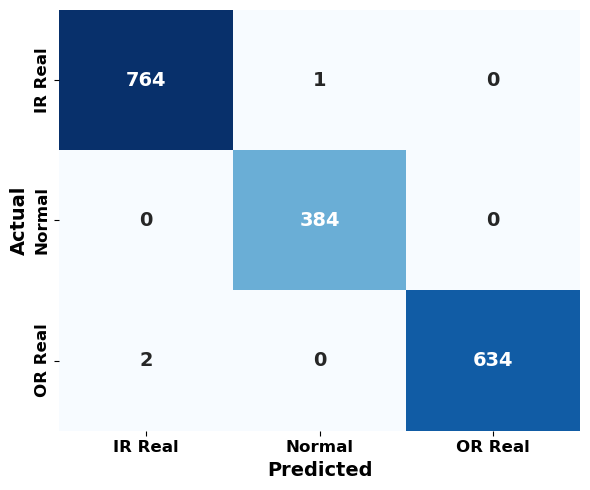

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure class_names is loaded from dataset
class_labels_real = class_names  # alias for clarity

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels_real,
            yticklabels=class_labels_real,
            cbar=False,
            annot_kws={"size": 14, "fontweight": "bold"})

# Axis labels and styling
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold', rotation=0)
plt.yticks(fontsize=12, fontweight='bold', rotation=90)

plt.grid(False)
plt.tight_layout()
plt.show()


🧠 Applying Supervised UMAP for better class separation...


c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


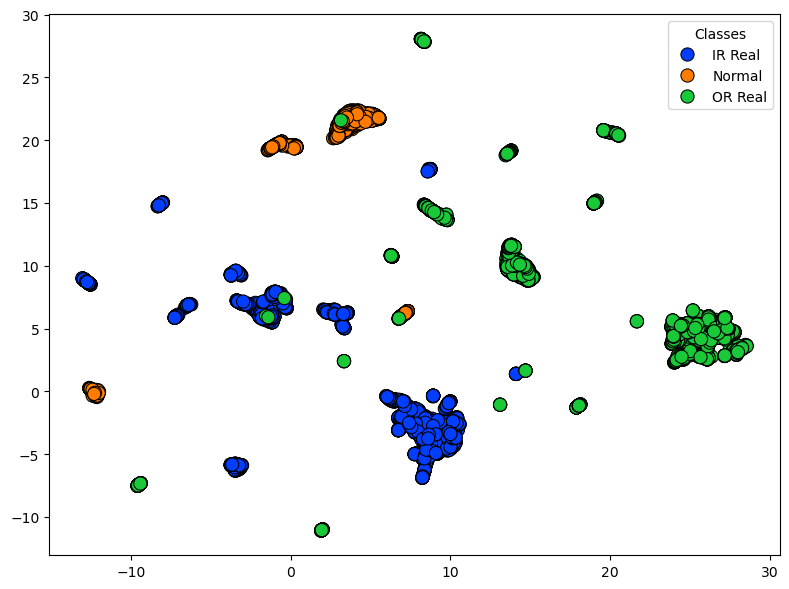

In [3]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

print("🧠 Applying Supervised UMAP for better class separation...")

# Supervised UMAP with 2 components
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.05,
    target_metric='categorical',
    random_state=42
)
features_umap_2d = reducer.fit_transform(features_std, y=labels)

# Plot UMAP results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=features_umap_2d[:, 0],
    y=features_umap_2d[:, 1],
    hue=[class_names[label] for label in labels],
    palette="bright",
    s=90, alpha=1, edgecolor='k'
)

plt.legend(loc='best', fontsize=10, title="Classes")
plt.tight_layout()
plt.show()


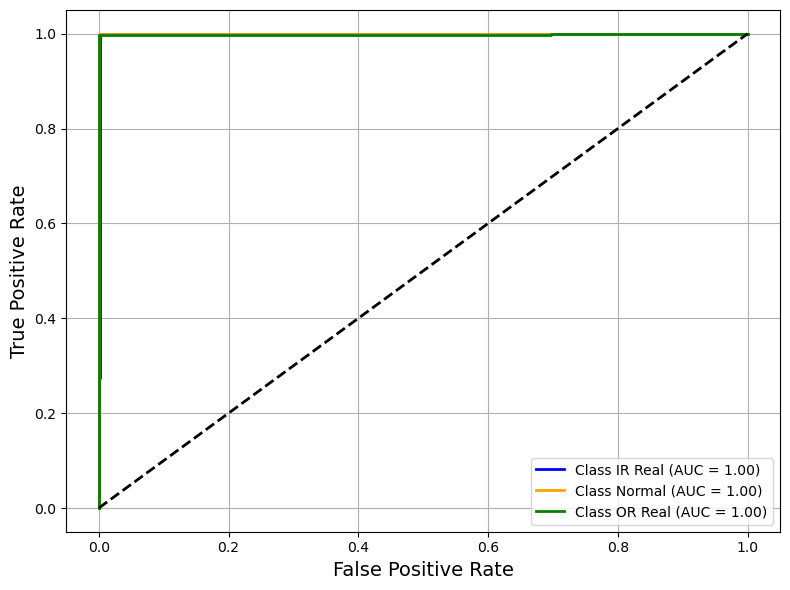

In [4]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from numpy import interp
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# Binarize labels for multi-class (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=np.unique(labels))
y_train_bin = label_binarize(y_train, classes=np.unique(labels))
n_classes = y_test_bin.shape[1]

# Wrap the ensemble model in OneVsRestClassifier
ensemble_ovr = OneVsRestClassifier(ensemble)
ensemble_ovr.fit(X_train, y_train_bin)
y_score = ensemble_ovr.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['blue', 'orange', 'green', 'red', 'purple', 'brown'])

plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

# Diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# === Set Paths ===
stft_path = r"E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_stft_data"
cwt_path = r"E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Define Transforms ===
transform_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
transform_efficientnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# === Feature Extraction ===
def extract_features(model, loader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device)
            out = model(x).cpu()
            features.append(out)
            labels.append(y)
    return torch.cat(features), torch.cat(labels)

# === Load Datasets ===
batch_size = 16
stft_dataset = datasets.ImageFolder(stft_path, transform=transform_inception)
cwt_dataset = datasets.ImageFolder(cwt_path, transform=transform_efficientnet)
assert stft_dataset.classes == cwt_dataset.classes

stft_loader = DataLoader(stft_dataset, batch_size=batch_size, shuffle=False)
cwt_loader = DataLoader(cwt_dataset, batch_size=batch_size, shuffle=False)

# === Load Pretrained Models ===
model_inc = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model_inc.AuxLogits.fc = nn.Identity()  # Disable aux branch manually
model_inc.fc = nn.Identity()


model_eff = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model_eff.classifier = nn.Identity()
model_eff = model_eff.to(device)

# === Extract and Save Features ===
cwt_features, labels = extract_features(model_eff, cwt_loader)
stft_features, _ = extract_features(model_inc, stft_loader)
features = torch.cat([cwt_features, stft_features], dim=1)

np.save("dual_features_mct.npy", features.numpy())
np.save("labels_mct.npy", labels.numpy())
print("✅ Features saved to disk.")


100%|██████████| 18/18 [00:18<00:00,  1.05s/it]

✅ Features saved to disk.


Epoch 1: Train Acc = 25.45%, Val Acc = 71.43%
Epoch 2: Train Acc = 51.79%, Val Acc = 82.14%
Epoch 3: Train Acc = 70.54%, Val Acc = 89.29%
Epoch 4: Train Acc = 75.45%, Val Acc = 89.29%
Epoch 5: Train Acc = 83.93%, Val Acc = 91.07%
Epoch 6: Train Acc = 89.29%, Val Acc = 89.29%
Epoch 7: Train Acc = 86.61%, Val Acc = 87.50%
Epoch 8: Train Acc = 91.07%, Val Acc = 91.07%
Epoch 9: Train Acc = 89.29%, Val Acc = 87.50%
Epoch 10: Train Acc = 87.95%, Val Acc = 92.86%
Epoch 11: Train Acc = 89.73%, Val Acc = 89.29%
Epoch 12: Train Acc = 91.96%, Val Acc = 89.29%
Epoch 13: Train Acc = 93.30%, Val Acc = 89.29%
Epoch 14: Train Acc = 94.64%, Val Acc = 94.64%
Epoch 15: Train Acc = 91.96%, Val Acc = 92.86%
Epoch 16: Train Acc = 92.86%, Val Acc = 92.86%
Epoch 17: Train Acc = 94.64%, Val Acc = 92.86%
Epoch 18: Train Acc = 95.54%, Val Acc = 92.86%
Epoch 19: Train Acc = 95.98%, Val Acc = 98.21%
Epoch 20: Train Acc = 97.77%, Val Acc = 92.86%
Epoch 21: Train Acc = 96.43%, Val Acc = 98.21%
Epoch 22: Train Acc = 

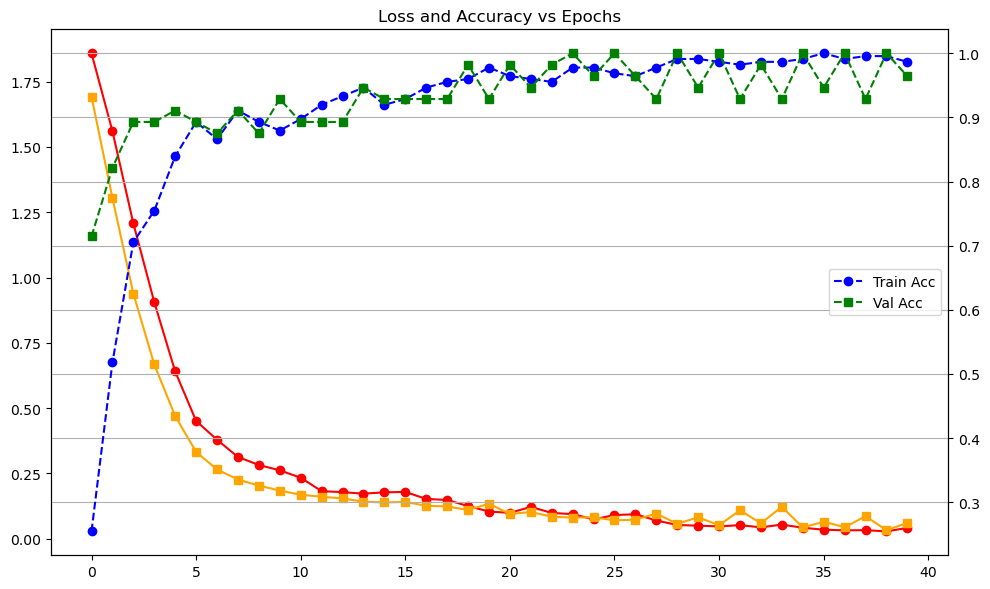

In [10]:
# === Load Saved Features ===
features = torch.tensor(np.load("dual_features_mct.npy"), dtype=torch.float32)
labels = torch.tensor(np.load("labels_mct.npy"), dtype=torch.long)

# === Encode Labels (if necessary) ===
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = torch.tensor(le.fit_transform(labels), dtype=torch.long)

# === Dataset and DataLoader ===
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = FeatureDataset(features, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# === MLP Classifier ===
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )
    def forward(self, x):
        return self.model(x)

model = MLP(features.shape[1], len(torch.unique(labels))).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

# === Training Loop ===
epochs = 40
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    model.eval()
    correct, total, running_loss = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            running_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
    val_losses.append(running_loss / total)
    val_accs.append(correct / total)
    print(f"Epoch {epoch+1}: Train Acc = {train_accs[-1]*100:.2f}%, Val Acc = {val_accs[-1]*100:.2f}%")

# === Plot
plt.figure(figsize=(10, 6))
plt.plot(train_losses, 'r-o', label="Train Loss")
plt.plot(val_losses, 'orange', marker='s', label="Val Loss")
plt.twinx()
plt.plot(train_accs, 'b--o', label="Train Acc")
plt.plot(val_accs, 'g--s', label="Val Acc")
plt.title("Loss and Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.grid(True)
plt.legend(loc="center right")
plt.tight_layout()
plt.savefig("final_loss_accuracy_curve.png", dpi=300)
plt.show()


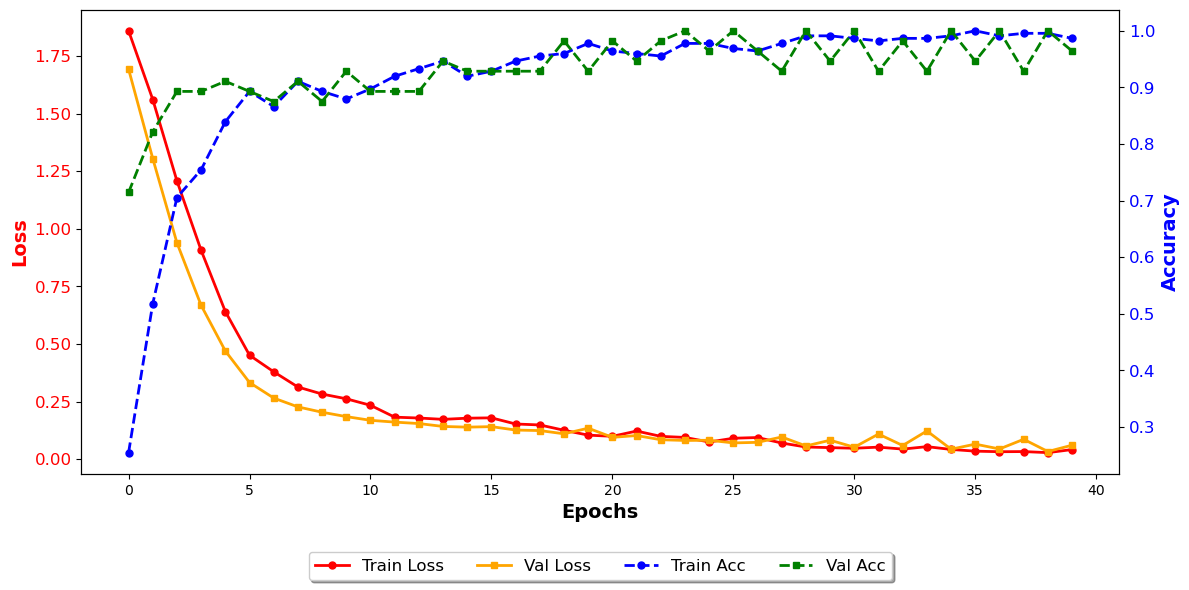

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Create axis for Loss (left y-axis)
ax1 = plt.gca()
l1 = ax1.plot(train_losses, 'r-o', label="Train Loss", linewidth=2, markersize=5)
l2 = ax1.plot(val_losses, 'orange', marker='s', label="Val Loss", linewidth=2, markersize=5)
ax1.set_ylabel("Loss", fontsize=14, color='red', fontweight = 'bold')
ax1.tick_params(axis='y', labelcolor='red', labelsize=12)
ax1.set_xlabel("Epochs", fontsize=14 , fontweight = 'bold')


# Create second axis for Accuracy (right y-axis)
ax2 = ax1.twinx()
l3 = ax2.plot(train_accs, 'b--o', label="Train Acc", linewidth=2, markersize=5)
l4 = ax2.plot(val_accs, 'g--s', label="Val Acc", linewidth=2, markersize=5)
ax2.set_ylabel("Accuracy", fontsize=14, color='blue', fontweight = 'bold')
ax2.tick_params(axis='y', labelcolor='blue', labelsize=12)


# Combine legends from both axes
lines = l1 + l2 + l3 + l4
labels = [line.get_label() for line in lines]

# Place the legend below the plot in one horizontal line
ax1.legend(
    lines,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    fontsize=12,
    frameon=True,
    fancybox=True,
    shadow=True
)

# Save and show
plt.tight_layout()
plt.savefig("final_loss_accuracy_curve_bold_legend.png", dpi=300, bbox_inches='tight')
plt.show()